In [1]:
%matplotlib inline


`Learn the Basics <intro.html>`_ ||
**Quickstart** ||
`Tensors <tensorqs_tutorial.html>`_ ||
`Datasets & DataLoaders <data_tutorial.html>`_ ||
`Transforms <transforms_tutorial.html>`_ ||
`Build Model <buildmodel_tutorial.html>`_ ||
`Autograd <autogradqs_tutorial.html>`_ ||
`Optimization <optimization_tutorial.html>`_ ||
`Save & Load Model <saveloadrun_tutorial.html>`_

Quickstart
===================
This section runs through the API for common tasks in machine learning. Refer to the links in each section to dive deeper.

Working with data
-----------------
PyTorch has two `primitives to work with data <https://pytorch.org/docs/stable/data.html>`_:
``torch.utils.data.DataLoader`` and ``torch.utils.data.Dataset``.
``Dataset`` stores the samples and their corresponding labels, and ``DataLoader`` wraps an iterable around
the ``Dataset``.


In [2]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor

PyTorch offers domain-specific libraries such as `TorchText <https://pytorch.org/text/stable/index.html>`_,
`TorchVision <https://pytorch.org/vision/stable/index.html>`_, and `TorchAudio <https://pytorch.org/audio/stable/index.html>`_,
all of which include datasets. For this tutorial, we  will be using a TorchVision dataset.

The ``torchvision.datasets`` module contains ``Dataset`` objects for many real-world vision data like
CIFAR, COCO (`full list here <https://pytorch.org/vision/stable/datasets.html>`_). In this tutorial, we
use the FashionMNIST dataset. Every TorchVision ``Dataset`` includes two arguments: ``transform`` and
``target_transform`` to modify the samples and labels respectively.



In [3]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

We pass the ``Dataset`` as an argument to ``DataLoader``. This wraps an iterable over our dataset, and supports
automatic batching, sampling, shuffling and multiprocess data loading. Here we define a batch size of 64, i.e. each element
in the dataloader iterable will return a batch of 64 features and labels.



In [4]:
batch_size = 64

# Create data loaders.
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


Read more about `loading data in PyTorch <data_tutorial.html>`_.




--------------




Creating Models
------------------
To define a neural network in PyTorch, we create a class that inherits
from `nn.Module <https://pytorch.org/docs/stable/generated/torch.nn.Module.html>`_. We define the layers of the network
in the ``__init__`` function and specify how data will pass through the network in the ``forward`` function. To accelerate
operations in the neural network, we move it to the GPU if available.



In [5]:
# Get cpu or gpu device for training.
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

# Define model
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.flatten = nn.Flatten()
        self.linear_relu_stack = nn.Sequential(
            nn.Linear(28*28, 512),
            nn.ReLU(),
            nn.Linear(512, 512),
            nn.ReLU(),
            nn.Linear(512, 10)
        )

    def forward(self, x):
        x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits

model = NeuralNetwork().to(device)
print(model)

Using cpu device
NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


Read more about `building neural networks in PyTorch <buildmodel_tutorial.html>`_.




--------------




Optimizing the Model Parameters
----------------------------------------
To train a model, we need a `loss function <https://pytorch.org/docs/stable/nn.html#loss-functions>`_
and an `optimizer <https://pytorch.org/docs/stable/optim.html>`_.



In [6]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

In a single training loop, the model makes predictions on the training dataset (fed to it in batches), and
backpropagates the prediction error to adjust the model's parameters.



In [7]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch % 100 == 0:
            loss, current = loss.item(), batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

We also check the model's performance against the test dataset to ensure it is learning.



In [8]:
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

The training process is conducted over several iterations (*epochs*). During each epoch, the model learns
parameters to make better predictions. We print the model's accuracy and loss at each epoch; we'd like to see the
accuracy increase and the loss decrease with every epoch.



In [9]:
epochs = 5
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)
print("Done!")

Epoch 1
-------------------------------
loss: 2.287847  [    0/60000]
loss: 2.279938  [ 6400/60000]
loss: 2.255647  [12800/60000]
loss: 2.260743  [19200/60000]
loss: 2.242502  [25600/60000]
loss: 2.209686  [32000/60000]
loss: 2.225864  [38400/60000]
loss: 2.187515  [44800/60000]
loss: 2.190738  [51200/60000]
loss: 2.164707  [57600/60000]
Test Error: 
 Accuracy: 46.7%, Avg loss: 2.152342 

Epoch 2
-------------------------------
loss: 2.159887  [    0/60000]
loss: 2.149029  [ 6400/60000]
loss: 2.087358  [12800/60000]
loss: 2.115740  [19200/60000]
loss: 2.064999  [25600/60000]
loss: 2.002492  [32000/60000]
loss: 2.039044  [38400/60000]
loss: 1.951753  [44800/60000]
loss: 1.960333  [51200/60000]
loss: 1.904207  [57600/60000]
Test Error: 
 Accuracy: 59.4%, Avg loss: 1.891804 

Epoch 3
-------------------------------
loss: 1.916206  [    0/60000]
loss: 1.892453  [ 6400/60000]
loss: 1.765930  [12800/60000]
loss: 1.823834  [19200/60000]
loss: 1.722749  [25600/60000]
loss: 1.659201  [32000/600

Read more about `Training your model <optimization_tutorial.html>`_.




--------------




Saving Models
-------------
A common way to save a model is to serialize the internal state dictionary (containing the model parameters).



In [10]:
torch.save(model.state_dict(), "model.pth")
print("Saved PyTorch Model State to model.pth")

Saved PyTorch Model State to model.pth


Loading Models
----------------------------

The process for loading a model includes re-creating the model structure and loading
the state dictionary into it.



In [11]:
model = NeuralNetwork()
model.load_state_dict(torch.load("model.pth"))

<All keys matched successfully>

This model can now be used to make predictions.



Predicted: "Ankle boot", Actual: "Ankle boot"
[-2.2320706844329834, -2.5548629760742188, -0.8139963746070862, -2.0916714668273926, -0.9245500564575195, 2.0587680339813232, -1.1970487833023071, 2.300644636154175, 1.48116934299469, 2.7620813846588135]


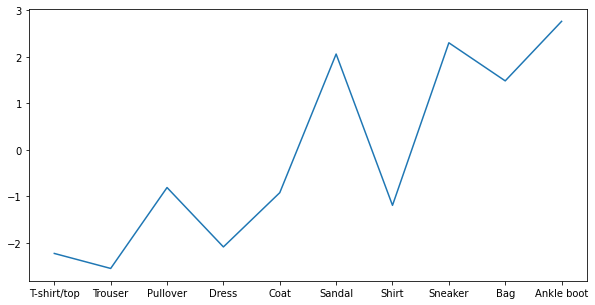

In [24]:
import matplotlib.pyplot as plt
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

model.eval()
x, y = test_data[0][0], test_data[0][1]
with torch.no_grad():
    pred = model(x)
    predicted, actual = classes[pred[0].argmax(0)], classes[y]
    print(f'Predicted: "{predicted}", Actual: "{actual}"')
    print(pred.squeeze().numpy().tolist())
    plt.figure(figsize=(10,5))
    plt.plot(classes, pred.squeeze().numpy().tolist())

Read more about `Saving & Loading your model <saveloadrun_tutorial.html>`_.


